# Mask Detection Demo - Automatic Pipeline (3 / 3)

> - To build the automated pipeline, Kubeflow Pipeline must be deployed.

The following example demonstrates how to package a project and how to run an automatic pipeline to train, evaluate, optimize and serve the mask detection model using our saved MLRun functions from the previous notebooks.

1. [Set up the project](#section_1)
2. [Write and save the workflow](#section_2)
3. [Run the pipeline](#section_3)
4. [Test the pipeline](#section_4)

Our **pipeline topology** will be:

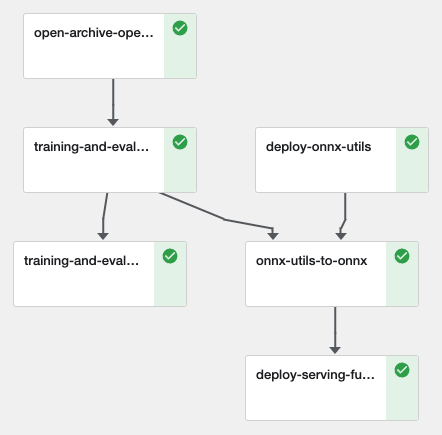


<a id="section_1"></a>
## 1. Set up the project

MLRun Project is a container for all the associated code, functions, jobs/workflows and artifacts. Projects can be mapped to git repositories to enable versioning, collaboration, and CI/CD. Read more about [MLRun projects](https://docs.mlrun.org/en/latest/projects/overview.html).

We will register the functions (code packages) and the workflow in the project and execute, projects can be saved/packaged into a git repository and loaded on another cluster or be executed as part of an automated CI/CD workflow. 

Create a project using `mlrun.get_or_create_project` (Make sure to load it in case it already exists):

In [1]:
import mlrun
import os

# Set our project's name:
project_name = "mask-detection"

# Create the project:
project = mlrun.get_or_create_project(name=project_name, context="./", user_project=True)

> 2023-04-09 04:23:00,522 [info] loaded project mask-detection from MLRun DB


Before we continue, **please select the desired framework** (comment and uncomment the below lines as needed):

In [2]:
framework = "tf-keras"
# framework = "pytorch"

### 1.1. Register the training, evaluation and serving functions
We'll use our training, evaluation and serving functions from the previous notebooks. To get them, we set them into the project using `project.set_function` and specify additional parameters such as the container image:

In [3]:
# Get our train/evaluation function like in the first notebook:
project.set_function(
    os.path.join(framework, "training-and-evaluation.py"),
    name="training-and-evaluation",
    kind="job",
    image="mlrun/ml-models",
)
    
# Get our serving function like in the second notebook:
project.set_function(
    os.path.join(framework, "serving.py"),
    name="serving", 
    kind="serving", 
    image="mlrun/ml-models",
)


### 1.2. Import the open archive and ONNX functions

We will import the following [MLRun Marketplace](https://www.mlrun.org/marketplace/) functions to our project:
* `open_archive` - Download the images dataset as seen in the first notebook.
* `onnx_utils` - ONNX integration in MLRun, some utils functions for the ONNX framework, optimizing and converting models from different framework to ONNX using MLRun.

> **Notice** we are using the same `project.set_function` with the `hub://` prefix.

In [4]:
# Import the `open_archive` function to download the images:
project.set_function("hub://open_archive", name="open-archive")


# Import the `onnx_utils` function to optimize the model:
project.set_function("hub://onnx_utils", name="onnx-utils")


In [5]:
# help function for mounting functions according to environment
def mount_functions(functions_list: list):
    for function_name in functions_list:
        function_object = project.get_function(function_name)
        function_object.apply(mlrun.auto_mount()) 
        if os.getenv('V3IO_ACCESS_KEY','False')=='False':
            function_object.spec.disable_auto_mount=False
        project.set_function(function_object)
        print("function {} mounted".format(function_name))
        
project_functions = ["training-and-evaluation","serving","open-archive","onnx-utils"]
        
mount_functions(project_functions)    

function training-and-evaluation mounted
function serving mounted
function open-archive mounted
function onnx-utils mounted


<a id="section_2"></a>
## 2. Write and save the workflow

We will use 2 functions:
* `mlrun.run_function` - Run a local or remote task as part of a local/kubeflow pipeline. Using this function to run our training and the rest of our functions will ensure that if the function is using output from another function, it will run only if the relying function is done.
* `mlrun.deploy_function` - Deploy a real-time (nuclio-based) function. Our serving function will be deployed with this.

All the functions above can receive a function object or just the function name (if it is set using `project.set_function` as we did above). We will access our project's functions as needed using the `project.get_function` method, which returns a function object by its name.

> **Note** The serving graph will now serve an ONNX model (not a tf.keras model like before), so we will use `mlrun.frameworks.onnx.ONNXModelServer`.

In [6]:
%%writefile workflow.py
import mlrun
from kfp import dsl


@dsl.pipeline(name="Mask Detection Pipeline")
def kfpipeline(
    archive_url: str,
    dataset_path: str,
    epochs: int,
    batch_size: int,
    lr: float,
    download_data_flag: int = 1
):
    # Get our project object:
    project = mlrun.get_current_project()

    ###########################################################
    ###############    Download the dataset:    ###############
    ###########################################################
    # Download only if needed (meaning if 'download_data_flag' = 1):
    with dsl.Condition(download_data_flag == 1) as download_data_condition:
        # Run it using the 'open_archive' handler:
        open_archive_run = mlrun.run_function(
            function="open-archive",
            handler="open_archive",
            name="download_data",
            inputs={"archive_url": archive_url},
            params={"target_path": dataset_path}
        )

    ####################################################
    ###############    Train a model:    ###############
    ####################################################    
    # Run it using our 'train' handler:
    training_run = mlrun.run_function(
        function="training-and-evaluation",
        handler="train",
        name="training",
        params={
            "dataset_path": dataset_path,
            "batch_size": batch_size,
            "lr": lr,
            "epochs": epochs
        },
        outputs=["model"]
    ).after(download_data_condition)

    ###################################################################
    ###############    Convert to ONNX and optimize:    ###############
    ###################################################################
    # Run it using the 'to_onnx' handler:
    to_onnx_run = mlrun.run_function(
        function="onnx-utils",
        handler="to_onnx",
        name="optimizing",
        params={
            "model_path": training_run.outputs['model'],
            "onnx_model_name": 'onnx_mask_detector'
        },
        outputs=["model"],
    )

    #########################################################
    ###############    Evaluate the model:    ###############
    #########################################################
    # Run it using our 'evaluate' handler:
    evaluation_run = mlrun.run_function(
        function="training-and-evaluation",
        handler="evaluate",
        name="evaluating",
        params={
            "model_path": training_run.outputs['model'],
            "dataset_path": dataset_path,
            "batch_size": batch_size
        }
    )

    ################################################################################
    ###############    Deploy the model as a serverless function:    ###############
    ################################################################################
    # Get the function:
    serving_function = project.get_function("serving")
    # Increase the time limit as the image may take long time to be downloaded:
    serving_function.spec.readiness_timeout = 60 * 20  # 20 minutes.
    # Set the topology and get the graph object:
    graph = serving_function.set_topology("flow", engine="async")
    # Build the serving graph:
    graph.to(handler="resize", name="resize")\
         .to(handler="preprocess", name="preprocess")\
         .to(class_name="mlrun.frameworks.onnx.ONNXModelServer", name="onnx_mask_detector", model_path=str(to_onnx_run.outputs["model"]))\
         .to(handler="postprocess", name="postprocess").respond()
    # Set the desired requirements:
    serving_function.with_requirements(requirements=["onnxruntime~=1.14.0", "onnxoptimizer~=0.3.0"])
    # Deploy the serving function:
    mlrun.deploy_function("serving")

Writing workflow.py


Note that after running the cell above, the `workflow.py` file is created. Saving your workflow to file allows you to run the project from a different environment.

In order to take this project with the functions we set and the workflow we saved over to a different environemnt, first set the workflow to the project. The workflow can be set using `project.set_workflow`. After setting it, we will save the project by calling `project.save`. When loaded, it can be run from another environment from both code and from cli. For more information regarding saving and loading a MLRun project, see the [documentation](https://docs.mlrun.org/en/latest/projects/overview.html).

In [7]:
# Register the workflow file:
workflow_name = "mask_detection_workflow"
project.set_workflow(workflow_name, "workflow.py")

# Save the project:
project.save()

<a id="section_3"></a>
## 3. Run the pipeline

We can immediately run the project, or save it to a git repository and load/run it on another cluster or CI/CD workflow. In order to load the project from a git you should run the following command (read more about [projects and CI/CD](https://docs.mlrun.org/en/latest/projects/overview.html)):

```python
project = mlrun.load_project(context="./", url="git://github.com/<org>/<project>.git")
```
or use the CLI command:

```bash
mlrun project -u "git://github.com/mlrun/project-demo.git" ./
```

We will run the pipeline using `project.run` with the workflow name we used:

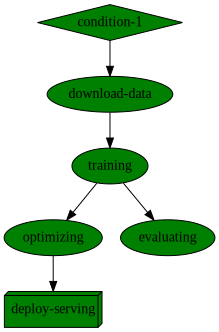

uid,start,state,name,parameters,results
...f01703be,Apr 09 04:28:50,completed,optimizing,model_path=store://artifacts/mask-detection-jovyan/mask_detector:ae044923-517f-41dd-b41f-486dcb556f49onnx_model_name=onnx_mask_detector,
...c7012512,Apr 09 04:25:55,completed,evaluating,model_path=store://artifacts/mask-detection-jovyan/mask_detector:ae044923-517f-41dd-b41f-486dcb556f49dataset_path=/home/jovyan/data/batch_size=32,model_path=store://artifacts/mask-detection-jovyan/mask_detector:ae044923-517f-41dd-b41f-486dcb556f49dataset_path=/home/jovyan/data/batch_size=32evaluation_loss=0.008318853249156112evaluation_accuracy=0.9949127906976745
...26c6a688,Apr 09 04:24:17,completed,training,dataset_path=/home/jovyan/data/batch_size=32lr=0.001epochs=3,dataset_path=/home/jovyan/data/batch_size=32epochs=3lr=0.0010000000474974513training_loss=0.008089840412139893training_accuracy=1.0001716613769531validation_loss=0.0041651009281243505validation_accuracy=1.0
...5e8f90ab,Apr 09 04:23:16,completed,download-data,target_path=/home/jovyan/data/,


ae044923-517f-41dd-b41f-486dcb556f49

In [8]:
dataset_path = os.environ.get('PWD', None)+"/data/"

project.run(
    name=workflow_name,
    arguments={
        "archive_url": mlrun.get_sample_path("data/prajnasb-generated-mask-detection/prajnasb_generated_mask_detection.zip"),
        "dataset_path": dataset_path,
        "epochs": 3,
        "batch_size": 32, 
        "lr": 1e-3,
        "download_data_flag": 1
    },
    watch=True
)

<a id="section_4"></a>
## 4. Test the pipeline

We will test it as seen in the previous notebook (with the `image_urls` list and `print_image_classification` function):

In [9]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# The local mock server is searching to import the functions, so here we simply import them from the file:
import sys
sys.path.insert(0, os.path.abspath(f"./{framework}"))
from serving import resize, preprocess, postprocess

# Our predictions headers:
classes = ["with mask", "without mask"]

# The image urls to use in the tests, feel free to add your own images and test them out:
image_urls = [
    'https://s3.envato.com/files/321053037/323%202020_June_PORTO_446-Edit.jpg',  # With mask
    'https://media.glamour.com/photos/5a425fd3b6bcee68da9f86f8/master/pass/best-face-oil.png'  # Without mask
]

def print_image_classification(image_url: str, prediction: dict):
    # Draw Image:
    response = requests.get(image_url)
    plt.imshow(Image.open(BytesIO(response.content)))
    
    # Print the prediction:
    print(f"Classified: {classes[prediction['class']]}\n")
    print(f"With mask probability:    {prediction['with_mask']}")
    print(f"Without mask probability: {prediction['without_mask']}")

2023-04-09 04:32:55.518500: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-09 04:32:55.518526: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


> 2023-04-09 04:32:56,803 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-mask-detection-jovyan-serving.mlrun.svc.cluster.local:8080/predict'}
Classified: with mask

With mask probability:    0.9967983365058899
Without mask probability: 0.0032017012126743793


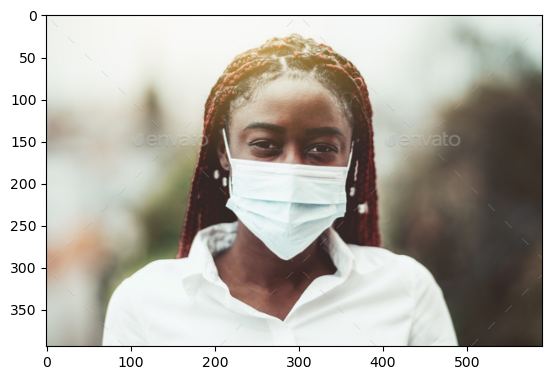

In [10]:
print_image_classification(
    image_url=image_urls[0], 
    prediction=project.get_function("serving").invoke(path='/predict', body={"data_url": [image_urls[0]]})
)

> 2023-04-09 04:32:57,233 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-mask-detection-jovyan-serving.mlrun.svc.cluster.local:8080/predict'}
Classified: without mask

With mask probability:    0.0007408472592942417
Without mask probability: 0.9992591738700867


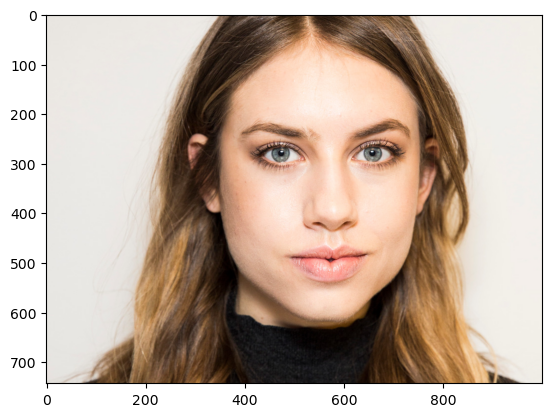

In [11]:
print_image_classification(
    image_url=image_urls[1], 
    prediction=project.get_function("serving").invoke(path='/predict', body={"data_url": [image_urls[1]]})
)